In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import optuna


sns.set_palette('crest')

c:\Users\Pedro\OneDrive - Instituto Maua de Tecnologia\5e_encounter_predictor\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../Data/results_v6.csv')
df.sample(5)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
73600,Cleric,6,18,2,Druid,7,14,2,Paladin,7,...,16,2,1,Grung Elite Warrior,2.0,13,49,humanoid,0.687808,1
39272,Wizzard,9,10,2,Monk,6,12,2,Bard,8,...,15,2,2,Giant Vulture,1.0,10,22,beast,0.345395,1
52142,Artificer,5,13,2,Warlock,9,12,2,Paladin,8,...,17,2,1,Wererat,2.0,12,33,humanoid,0.909042,1
84680,Wizzard,20,14,3,Artificer,22,16,3,Artificer,19,...,10,3,1,Kruthik Hive Lord,5.0,20,102,monstrosity,0.000000,3
58700,Paladin,10,17,2,Druid,13,14,2,Monk,20,...,12,2,10,Warhorse,0.5,11,19,beast,0.000000,2


In [3]:
df = df[df['p1_class'] != '22']
df = df[df['dificulty'] >= 0]
df = df[df['monster_cr'] != -1]
df = df[df['players_level'] <= 5]
print(df.shape)
df.head()

(102817, 24)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,14,3,1,Efreeti,11.00,17,200,elemental,0.869491,5
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,15,3,10,Giant Bat,0.25,13,22,beast,0.067640,3
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,2,1,Galeb Duhr,6.00,16,85,elemental,1.000000,2
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,13,3,1,Blue Slaad,7.00,15,123,aberration,0.285597,3
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,13,3,4,Lizardfolk Shaman,2.00,13,27,humanoid,0.445773,4


In [4]:
df['TPK'] = df['dificulty'] == 0
df.drop(columns=['dificulty','monster_name'], axis=1, inplace=True)
print(df.shape)
df.head()

(102817, 23)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,monster_type,players_level,TPK
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,43,14,3,1,11.00,17,200,elemental,5,False
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,25,15,3,10,0.25,13,22,beast,3,False
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,14,2,1,6.00,16,85,elemental,2,False
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,27,13,3,1,7.00,15,123,aberration,3,False
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,25,13,3,4,2.00,13,27,humanoid,4,False


In [5]:
df_test = pd.read_csv('../Data/test_sample.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4498 entries, 0 to 4497
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         4498 non-null   object 
 1   p1_hp            4498 non-null   int64  
 2   p1_ac            4498 non-null   int64  
 3   p1_avg_save      4498 non-null   int64  
 4   p2_class         4498 non-null   object 
 5   p2_hp            4498 non-null   int64  
 6   p2_ac            4498 non-null   int64  
 7   p2_avg_save      4498 non-null   int64  
 8   p3_class         4498 non-null   object 
 9   p3_hp            4498 non-null   int64  
 10  p3_ac            4498 non-null   int64  
 11  p3_avg_save      4498 non-null   int64  
 12  p4_class         4498 non-null   object 
 13  p4_hp            4498 non-null   int64  
 14  p4_ac            4498 non-null   int64  
 15  p4_avg_save      4498 non-null   int64  
 16  num_of_monsters  4498 non-null   int64  
 17  monster_name  

In [6]:
df_test_result = df_test['dificulty']==0
df_test_result.head()

0    False
1    False
2    False
3    False
4     True
Name: dificulty, dtype: bool

In [7]:
df_test.drop(columns=['monster_name','dificulty'], inplace=True)
print(df_test.shape)
df_test.head()

(4498, 22)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_class,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,monster_type,players_level
0,Fighter,10,18,2,Artificer,9,17,2,Cleric,6,...,Cleric,8,18,2,1,1.00,13,28,beast,1
1,Paladin,40,18,3,Rogue,25,16,3,Fighter,37,...,Ranger,57,17,3,1,5.00,15,75,monstrosity,5
2,Warlock,15,13,2,Ranger,17,16,2,Fighter,17,...,Cleric,12,14,2,2,2.00,13,30,beast,2
3,Monk,16,13,3,Monk,18,11,3,Paladin,26,...,Artificer,30,12,3,1,5.00,13,95,beast,3
4,Wizzard,4,11,2,Paladin,11,15,2,Sorcerer,6,...,Bard,6,16,2,10,0.25,15,11,construct,1


<Axes: xlabel='TPK', ylabel='count'>

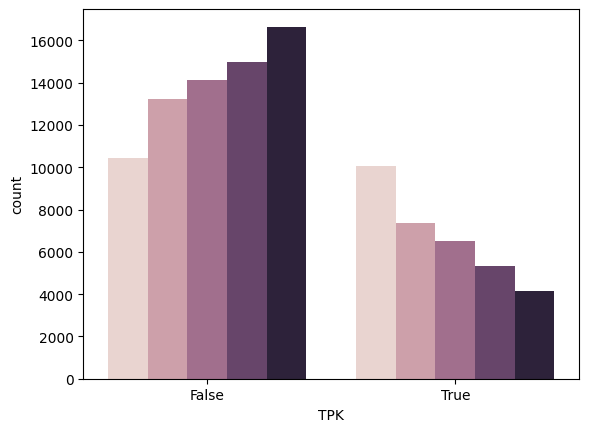

In [8]:
sns.countplot(x='TPK', data=df, hue='players_level', legend=False)

In [9]:
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['TPK']).sort_values(ascending = False)

TPK                1.000000
num_of_monsters    0.302892
players_level      0.204874
p3_hp              0.203828
p1_hp              0.202123
p2_hp              0.201363
p4_hp              0.200979
p2_avg_save        0.173201
p3_avg_save        0.173201
p4_avg_save        0.173201
p1_avg_save        0.173201
p3_ac              0.041813
p4_ac              0.040716
p1_ac              0.040125
p2_ac              0.036435
monster_cr         0.036085
monster_hp         0.009135
monster_ac         0.003594
Name: TPK, dtype: float64

In [10]:
X = df.drop(columns=['TPK'], axis=1)
Y = df['TPK']

In [11]:
encoder_class = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

features_df = encoder_class.fit_transform(X[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']])
X_encoded = pd.concat([X, features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type'])
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102817 entries, 0 to 103085
Data columns (total 83 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p1_hp                     102817 non-null  int64  
 1   p1_ac                     102817 non-null  int64  
 2   p1_avg_save               102817 non-null  int64  
 3   p2_hp                     102817 non-null  int64  
 4   p2_ac                     102817 non-null  int64  
 5   p2_avg_save               102817 non-null  int64  
 6   p3_hp                     102817 non-null  int64  
 7   p3_ac                     102817 non-null  int64  
 8   p3_avg_save               102817 non-null  int64  
 9   p4_hp                     102817 non-null  int64  
 10  p4_ac                     102817 non-null  int64  
 11  p4_avg_save               102817 non-null  int64  
 12  num_of_monsters           102817 non-null  int64  
 13  monster_cr                102817 non-null  float6

In [12]:
test_features_df = encoder_class.transform(df_test[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']])
df_test_encoded = pd.concat([df_test, test_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type'])
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4498 entries, 0 to 4497
Data columns (total 83 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p1_hp                     4498 non-null   int64  
 1   p1_ac                     4498 non-null   int64  
 2   p1_avg_save               4498 non-null   int64  
 3   p2_hp                     4498 non-null   int64  
 4   p2_ac                     4498 non-null   int64  
 5   p2_avg_save               4498 non-null   int64  
 6   p3_hp                     4498 non-null   int64  
 7   p3_ac                     4498 non-null   int64  
 8   p3_avg_save               4498 non-null   int64  
 9   p4_hp                     4498 non-null   int64  
 10  p4_ac                     4498 non-null   int64  
 11  p4_avg_save               4498 non-null   int64  
 12  num_of_monsters           4498 non-null   int64  
 13  monster_cr                4498 non-null   float64
 14  monster_

In [13]:
print(len(Y))
print(len(X_encoded))

102817
102817


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=7)

[0]	validation_0-logloss:0.52058	validation_1-logloss:0.52155


c:\Users\Pedro\OneDrive - Instituto Maua de Tecnologia\5e_encounter_predictor\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "eval_set" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-logloss:0.17656	validation_1-logloss:0.21990


<Axes: >

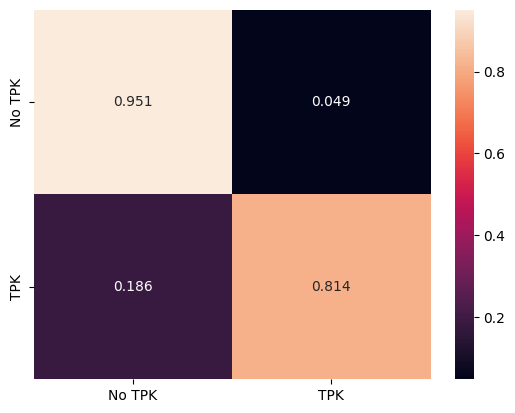

In [15]:
clfXGB = XGBClassifier(early_stopping_rounds=10, eval_set=[(X_test, Y_test)])
clfXGB.fit( X_train,
            Y_train,
            verbose=100,
            eval_set=[(X_train, Y_train),(X_test, Y_test)]
            )

matrix = confusion_matrix(Y_test, clfXGB.predict(X_test))
confusion_matrix_float = [[],[]]
confusion_matrix_float[0].append(matrix[0][0]/(matrix[0].sum()))
confusion_matrix_float[0].append(1 - confusion_matrix_float[0][0])
confusion_matrix_float[1].append(matrix[1][0]/(matrix[1].sum()))
confusion_matrix_float[1].append(1 - confusion_matrix_float[1][0])

confusion_matrix_float

sns.heatmap(confusion_matrix_float, annot=True, fmt='.3f', xticklabels=['No TPK', 'TPK'], yticklabels=['No TPK', 'TPK'])

In [16]:
test = classification_report(Y_test, clfXGB.predict(X_test))
test.split('\n')


['              precision    recall  f1-score   support',
 '',
 '       False       0.91      0.95      0.93     13877',
 '        True       0.89      0.81      0.85      6687',
 '',
 '    accuracy                           0.91     20564',
 '   macro avg       0.90      0.88      0.89     20564',
 'weighted avg       0.91      0.91      0.91     20564',
 '']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

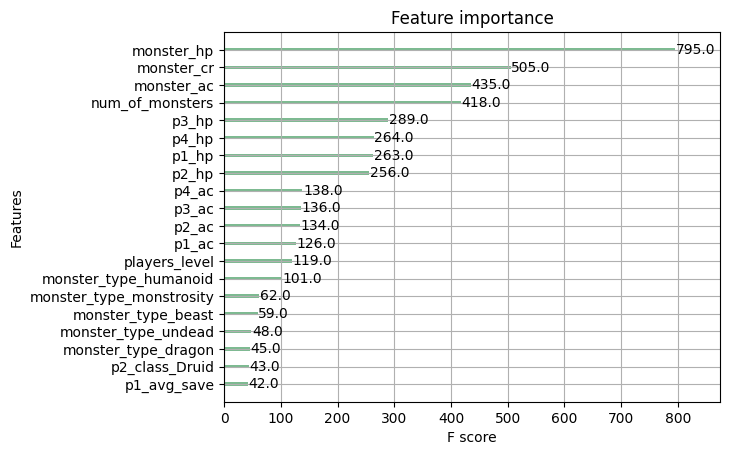

In [17]:
plot_importance(clfXGB, max_num_features=20)

In [18]:


skf = StratifiedKFold(10, shuffle=True, random_state=7)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=7, n_jobs=-1)

    return cross_val_score(cls, X_train, Y_train,
                           cv=skf, scoring='accuracy').mean()

In [19]:
# # Criação do estudo e procura pelos hiperparâmetros
# studyXGB = optuna.create_study(direction='maximize', study_name='classification')
# studyXGB.optimize(objective, n_trials=100, n_jobs=-1)
# studyXGB.best_params

In [20]:
# params = studyXGB.best_params
params = {
    'n_estimators': 147,
    'max_depth': 5,
    'learning_rate': 0.2,
    'gamma': 0.1,
    'min_child_weight': 4,
    'colsample_bytree': 0.7
}

In [21]:
# pesos = np.round(np.arange(0.5, 3, 0.01), 5)

# params['random_state'] = 7

# for i in pesos:
#     params['scale_pos_weight'] = i

#     xgb_optuna = XGBClassifier()
#     xgb_optuna.set_params(**params)

#     xgb_optuna.fit(X_train, Y_train)
#     Y_pred = xgb_optuna.predict(X_test)

#     tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred, normalize='true').ravel()
#     if abs(tn - tp) <= 0.01:

#         print(i)
#         print(classification_report(Y_test, Y_pred))

#         print()

0.9605766439167486
              precision    recall  f1-score   support

       False       0.95      0.88      0.91     13877
        True       0.79      0.89      0.84      6687

    accuracy                           0.89     20564
   macro avg       0.87      0.89      0.87     20564
weighted avg       0.89      0.89      0.89     20564



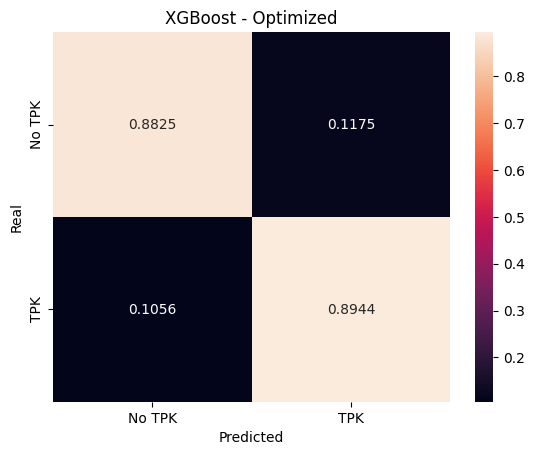

In [22]:
params['scale_pos_weight'] = 2.19

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, Y_train)

# Matriz de confusão do modelo XGBoost otimizado
ax = sns.heatmap(confusion_matrix(Y_test, xgb_optuna.predict(X_test), normalize='true'), annot=True, fmt='.4f', xticklabels=['No TPK', 'TPK'], yticklabels=['No TPK', 'TPK'])
ax.set_title('XGBoost - Optimized')
ax.set_xlabel('Predicted')
ax.set_ylabel('Real');
print(roc_auc_score(Y_test, xgb_optuna.predict_proba(X_test)[:,1]))
print(classification_report(Y_test, xgb_optuna.predict(X_test)))


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

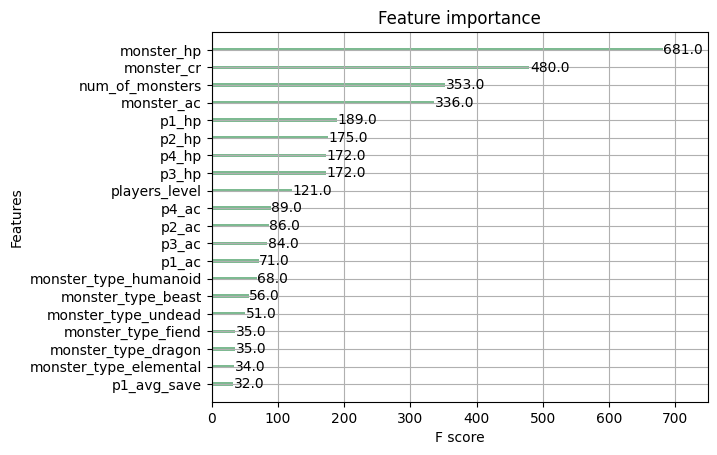

In [23]:
plot_importance(xgb_optuna, max_num_features=20)

In [24]:
# with open ('normalizer.pkl', 'rb') as f:
#     normalizer = pickle.load(f)
from sklearn.preprocessing import MinMaxScaler


normalizer_class = MinMaxScaler()
X_encoded_normalized = normalizer_class.fit_transform(X_encoded)
X_encoded_normalized = pd.DataFrame(X_encoded_normalized, columns=X_encoded.columns)


In [25]:
df_test_encoded_normalized = normalizer_class.transform(df_test_encoded)
df_test_encoded_normalized = pd.DataFrame(df_test_encoded_normalized, columns=df_test_encoded.columns)

In [26]:
X_train_normalized, X_test_normalized, Y_train_normalized, Y_test_normalized = train_test_split(X_encoded_normalized, Y, test_size=0.2, random_state=7)

In [27]:
skf = StratifiedKFold(10, shuffle=True, random_state=7)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=7, n_jobs=-1)

    return cross_val_score(cls, X_train_normalized, Y_train_normalized,
                           cv=skf, scoring='accuracy').mean()

In [126]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', study_name='classification')
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)
studyXGB.best_params

[I 2023-12-07 15:46:59,330] A new study created in memory with name: classification
[I 2023-12-07 15:47:29,759] Trial 1 finished with value: 0.8399936416300307 and parameters: {'n_estimators': 79, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.1, 'min_child_weight': 3, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.8399936416300307.
[I 2023-12-07 15:47:32,023] Trial 4 finished with value: 0.8598470148398917 and parameters: {'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.15000000000000002, 'gamma': 0.1, 'min_child_weight': 7, 'colsample_bytree': 0.7}. Best is trial 4 with value: 0.8598470148398917.
[I 2023-12-07 15:47:32,778] Trial 5 finished with value: 0.8512394490890698 and parameters: {'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'min_child_weight': 4, 'colsample_bytree': 0.6000000000000001}. Best is trial 4 with value: 0.8598470148398917.
[I 2023-12-07 15:47:32,975] Trial 8 finished with value: 0.8377687959520447 and par

{'n_estimators': 150,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.7}

In [127]:
params = {
    'n_estimators': 150,
    'max_depth': 5,
    'learning_rate': 0.2,
    'gamma': 0.2,
    'min_child_weight': 6,
    'colsample_bytree': 0.7
}

In [128]:
pesos = np.round(np.arange(0.5, 3, 0.01), 5)

params['random_state'] = 7

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train_normalized, Y_train_normalized)
    Y_pred = xgb_optuna.predict(X_test_normalized)

    tn, fp, fn, tp = confusion_matrix(Y_test_normalized, Y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.01:

        print(i)
        print(classification_report(Y_test_normalized, Y_pred))

        print()

2.0
              precision    recall  f1-score   support

       False       0.94      0.89      0.91     13877
        True       0.79      0.89      0.84      6687

    accuracy                           0.89     20564
   macro avg       0.87      0.89      0.88     20564
weighted avg       0.89      0.89      0.89     20564


2.01
              precision    recall  f1-score   support

       False       0.94      0.89      0.91     13877
        True       0.79      0.88      0.83      6687

    accuracy                           0.88     20564
   macro avg       0.86      0.88      0.87     20564
weighted avg       0.89      0.88      0.89     20564


2.02
              precision    recall  f1-score   support

       False       0.94      0.89      0.91     13877
        True       0.79      0.88      0.83      6687

    accuracy                           0.89     20564
   macro avg       0.87      0.89      0.87     20564
weighted avg       0.89      0.89      0.89     20564


2.

0.9583194008149036
              precision    recall  f1-score   support

       False       0.94      0.88      0.91     13877
        True       0.78      0.89      0.83      6687

    accuracy                           0.88     20564
   macro avg       0.86      0.88      0.87     20564
weighted avg       0.89      0.88      0.88     20564



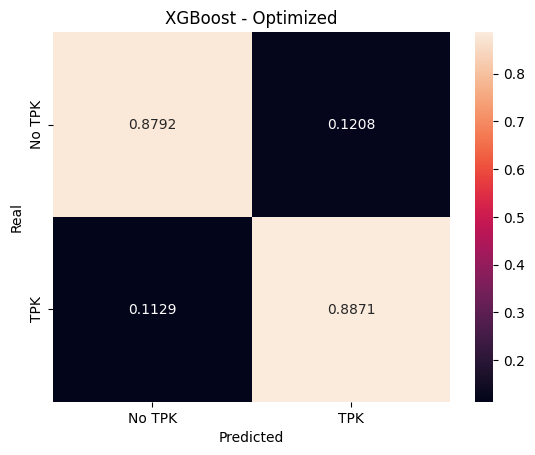

In [129]:
params['scale_pos_weight'] = 2.17

xgb_optuna_normalized = XGBClassifier()
xgb_optuna_normalized.set_params(**params)

xgb_optuna_normalized.fit(X_train_normalized, Y_train_normalized)

# Matriz de confusão do modelo XGBoost otimizado
ax = sns.heatmap(confusion_matrix(Y_test_normalized, xgb_optuna_normalized.predict(X_test_normalized), normalize='true'), annot=True, fmt='.4f', xticklabels=['No TPK', 'TPK'], yticklabels=['No TPK', 'TPK'])
ax.set_title('XGBoost - Optimized')
ax.set_xlabel('Predicted')
ax.set_ylabel('Real');
print(roc_auc_score(Y_test_normalized, xgb_optuna_normalized.predict_proba(X_test_normalized)[:,1]))
print(classification_report(Y_test_normalized, xgb_optuna_normalized.predict(X_test_normalized)))


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

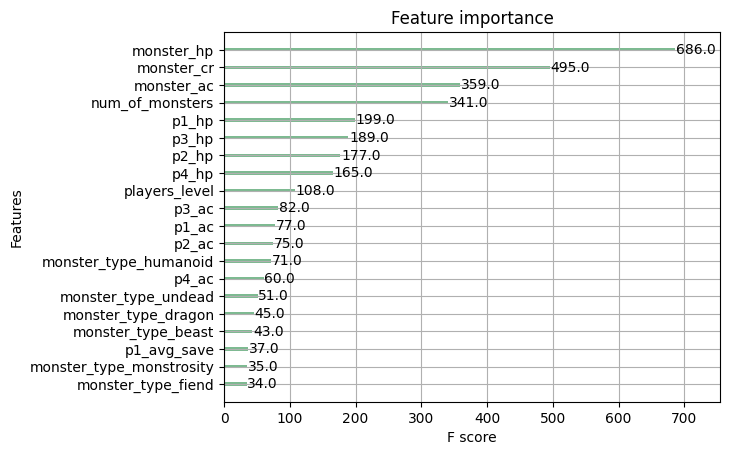

In [130]:
plot_importance(xgb_optuna_normalized, max_num_features=20)

In [197]:
xgb_optuna_normalized.save_model('model_opt_normalized_classification.ubj')

In [198]:
from random import randint

def predict(model,test, y,normalizer):
    input_test = randint(0, len(test))
    row_input = pd.DataFrame(test.iloc[input_test]).T
    try:
        print_input = pd.DataFrame(normalizer.inverse_transform(row_input), columns=row_input.columns)
    except:
        print('ruim')
        print_input = row_input 
    print('Input: ')
    display(row_input)
    print(f'The combat was between 4 players level {print_input.players_level.values[0]} against {print_input.num_of_monsters.values[0]} monster(s) CR {print_input.monster_cr.values[0]}')
    print('Expected: ', y.iloc[input_test])
    print(type(row_input.values))
    print('Predicted: ', bool(model.predict(row_input.values)[0]))

In [199]:
predict(xgb_optuna_normalized, df_test_encoded_normalized, df_test_result, normalizer=normalizer_class)

Input: 


,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_dragon,monster_type_elemental,monster_type_fey,monster_type_fiend,monster_type_giant,monster_type_humanoid,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead
1859,0.528571,0.2,1.0,0.710145,0.5,1.0,0.507042,0.5,1.0,0.550725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The combat was between 4 players level 5.0 against 1.0 monster(s) CR 10.0
Expected:  False
<class 'numpy.ndarray'>
Predicted:  False


In [231]:
from xgboost import XGBRegressor


model_loaded_class = XGBClassifier()
model_loaded_class.load_model('model_opt_normalized_classification.ubj')
model_loaded_reg = XGBRegressor()
model_loaded_reg.load_model('model_OPT_NORMALIZED.ubj')
new_data = pd.read_csv('../Data/test_sample.csv', encoding='utf-8')
new_data = new_data.iloc[randint(0,4000)].T.to_frame().T

# with open ('encoder.pkl', 'rb') as f:
#     encoder = pickle.load(f)
# with open ('normalizer.pkl', 'rb') as f:
#     normalizer = pickle.load(f)

classification_features_df = encoder_class.transform(new_data[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']])
classification_data_encoded = pd.concat([new_data, classification_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type', 'monster_name','dificulty'])
classification_data_encoded_normalized = normalizer_class.transform(classification_data_encoded)

classification_data_encoded_normalized
print(model_loaded_class.predict(classification_data_encoded_normalized))
print(model_loaded_reg.predict(classification_data_encoded_normalized))
print(new_data.dificulty.values[0])


[1]
[0.09005676]
0.0
